In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd

from icecream import ic
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from Data.Data_Loader import Data_Loader
from Model.simple_model import Pretrain_AutoEncoder
from Model.simple_model import DeepSVDD
from deep_svdd_train import DeepSVDDTrain
from pretrain import PreTrain

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
#import tensorflow_probability as tfp
import pandas as pd

from icecream import ic
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers, losses
# from tensorflow.keras import lossesf
from tensorflow.keras.models import Model

from Data.Data_Loader import Mnist_Data_Loader
from Model.simple_model import Pretrain_AutoEncoder
from Model.simple_model import DeepSVDD
from Preprocessing.preprocessing import convert_str_to_bool

MODEL_SAVE_DIR_PATH = os.path.abspath('pretrain_weight')

class CustomCallback(keras.callbacks.Callback):
    # def on_epoch_begin(self, epoch, logs=None):
    #     keys = list(logs.keys())
    #     print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print(f"this is test case{epoch}")


class Train:
    def __init__(self, config: dict, latent_dim, input_dim):
        self.config = config
        self.pretrain_ae = Pretrain_AutoEncoder(latent_dim=latent_dim, input_dim=input_dim)
        self.svdd = DeepSVDD(latent_dim=latent_dim, input_dim=input_dim)
        self.value = {'c': config['c'],
                      'R': config['R'],
                      'nu': config['nu']}
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dist_op = 0.0
        self.data_loader = Mnist_Data_Loader(self.config)
        self.check()
        self.dist = 0.0

    # weight 저장 폴더 생성
    def check(self):
        if not os.path.exists('pretrain_weight'):
            os.mkdir('pretrain_weight')

    def pretrain(self):
        ae = self.pretrain_ae.build_graph()
        train_dataset_pre, test_dataset_pre = self.data_loader.pretrain_mnist()
        loss_object = tf.keras.losses.MeanSquaredError()
        optimizer = tf.keras.optimizers.Adam()

        ae.compile(optimizer=optimizer, loss=loss_object, metrics=['mae'])
        hist = ae.fit(train_dataset_pre, epochs=self.config['pretrain_epoch'])

        encoder_part = Model(ae.get_layer('inputs').input, ae.get_layer('latent').output)
        self.save_weights_pretrain(encoder_part)

        return hist, ae

    def save_weights_pretrain(self, model):
        """학습된 AutoEncoder 가중치를 DeepSVDD모델에 Initialize해주는 함수"""
        print(f"Saved to {os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5')}")
        model.save_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))  # model save

    def get_c(self, eps=0.1):
        """Initializing the center for the hypersphere"""
        if self.config['pretrain']:
            self.svdd.load_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))
            train_dataset_pre, _ = self.data_loader.pretrain_mnist()
            z_list = []
            for (x_train_batch, _) in train_dataset_pre:
                z = self.svdd.predict(x_train_batch)
                z_list.append(z)
            z_list = np.concatenate(z_list)
            c = z_list.mean(axis=0)
            # & ==> and로 바꾸기(속도가 더 빠름)
            c[(abs(c) < eps) & (c < 0)] = -eps  # avoid trivial solution that c = 0 is trivial solution
            c[(abs(c) < eps) & (c > 0)] = eps

        else:
            c = np.array(eps * self.svdd.latent_dim)  # pretrain model 없을시 초기화

        self.value['c'] = c

    def weight_loss(self, y_true, y_pred):
        dist_op = tf.reduce_sum(tf.square(y_pred - self.value['c']), axis=-1) # evaluation 할 때 distance, score function 생성
        self.dist = (tf.identity(dist_op))
        #self.dist_op = (tf.square(y_pred - self.value['c']))
        score_op = (dist_op - self.value['R'] ** 2)
        penalty = tf.reduce_mean(tf.maximum(score_op, tf.zeros_like(score_op)))  # tf.reduce_mean 추가
        loss_op = self.value['R'] ** 2 + (1 / self.value['nu']) * penalty
        return loss_op

    def radius(self, epoch, logs={}):
        if (epoch+1) % 5 == 0:
            self.get_r()

    def svdd_train_fit(self):
        if self.config['pretrain']:
            self.svdd.build((1,self.input_dim))
            self.svdd.load_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))
            self.get_c()

        train_dataset, test_dataset = self.data_loader.svdd_mnist()
        optimizer = tfa.optimizers.AdamW(weight_decay=self.config['weight_decay'])
        loss_obj = self.weight_loss
        printlogcallback = tf.keras.callbacks.LambdaCallback(on_epoch_end=self.radius)

        self.svdd.compile(optimizer=optimizer, loss=loss_obj)
        for epoch_ in range(self.config['svdd_epoch']):
            self.svdd.fit(train_dataset, epochs=1)
            if (epoch_+1) % 5 == 0:
                self.get_r()

        return self.svdd, self.value

    def svdd_train(self, is_train=True):
        if self.config['pretrain']:
            self.svdd.build((1,self.input_dim))
            self.svdd.load_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))
            self.get_c()
        
        train_dataset, test_dataset = self.data_loader.svdd_mnist(is_train)
        """training code"""
        # loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
        #loss_object = self.weight_loss()
        # optimizer = tf.keras.optimizers.Adam()
        optimizer = tfa.optimizers.AdamW(weight_decay=self.config['weight_decay'])

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        epochs = self.config['svdd_epoch']
        for epoch in range(epochs):
            print(f"Start of epoch {epoch + 1}")

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    reconstructed = self.svdd(x_batch_train)
                    # Compute reconstruction loss
                    loss = self.weight_loss(y_batch_train, reconstructed)

                grads = tape.gradient(loss, self.svdd.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.svdd.trainable_weights))

                train_loss(loss)
                #if (step + 1) % 50 == 0:
                    #print(f"step {step + 1}: mean loss = {train_loss.result():.4f}")
                if (epoch + 1) % 5 == 0:
                    self.get_r()
            print(f"epoch {epoch + 1}: mean loss = {train_loss.result():.4f}")

        return self.svdd, self.value

    def get_r(self):
        #self.value['R'] = tfp.stats.quantiles(tf.sqrt(self.dist), 1 - self.value['nu'])
        self.value['R'] = np.quantile(np.sqrt(self.dist), 1 - self.value['nu'])

In [2]:
json_path = os.path.join(os.path.abspath('config'), 'config.json')
with open(json_path, 'r') as f:
    config = json.load(f)
    config = convert_str_to_bool(config)

In [3]:
pretrain_ae = Pretrain_AutoEncoder(100, 784)

In [4]:
train = Train(config, 100, 784)

In [5]:
hist, ae = train.pretrain()

Epoch 1/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0137 - mae: 0.0301
Epoch 2/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0078 - mae: 0.0190
Epoch 3/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0070 - mae: 0.0173
Epoch 4/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0065 - mae: 0.0163
Epoch 5/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0061 - mae: 0.0155
Epoch 6/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0052 - mae: 0.0143
Epoch 7/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0050 - mae: 0.0138
Epoch 8/8
211/211 [==============================] - 1s 4ms/step - loss: 0.0049 - mae: 0.0135
Saved to C:\Users\BISTel\PycharmProjects\bistel\Deep_SVDD\pretrain_weight\pretrain_ae.hdf5


In [6]:
svdd, value = train.svdd_train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Start of epoch 1
epoch 1: mean loss = 9.1320
Start of epoch 2
epoch 2: mean loss = 6.3121
Start of epoch 3
epoch 3: mean loss = 4.8935
Start of epoch 4
epoch 4: mean loss = 4.1591
Start of epoch 5
epoch 5: mean loss = 3.3821
Start of epoch 6
epoch 6: mean loss = 2.8597
Start of epoch 7
epoch 7: mean loss = 2.4849
Start of epoch 8
epoch 8: mean loss = 2.2028
Start of epoch 9
epoch 9: mean loss = 1.9835
Start of epoch 10
epoch 10: mean loss = 1.8070


In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np

from Data.Data_Loader import Mnist_Data_Loader

class Test:
    def __init__(self, config: dict, svdd, value: dict, pretrain):
        self.config = config
        self.svdd = svdd
        self.pretrain = pretrain
        self.value = value
        self.data_loader = Mnist_Data_Loader(self.config)

    def pretrain_evaluation(self):
        train_dataset, test_dataset = self.data_loader.pretrain_mnist()
        self.pretrain.buld()
        self.pretrain.load_weights((os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5')))

        '''
        pred = self.pretrain.predict(test_dataset)
        pred = pred.reshape(-1,28,28)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(pred[0])
        ax[1].imshow(pred[1])
        plt.show()
        '''
        return self.pretrain.predict(test_dataset)  # shape 확인

    def dist(self, pred):
        return np.sqrt(np.sum(((self.value['c'] - pred) ** 2), axis=-1))

    def score(self, pred):
        return self.dist(pred) - self.value['R']

        #scores_normal_index = np.where(scores > 0)

    def svdd_evaluation(self, is_valid=False):
        train_dataset, test_dataset = self.data_loader.svdd_mnist()
        
        if is_valid:
            self.svdd.predict(train_dataset)
        else:
            pre = self.svdd.predict(test_dataset)
            


        

    def plotting(self):
        pass


In [44]:
import numpy as np

import tensorflow as tf

from tensorflow import keras


class Mnist_Data_Loader:
    def __init__(self, config):
        self.type_of_data = config['data_type']
        self.normal_class = config['normal_class']
        self.abnormal_class = config['abnormal_class']
        self.config = config

    def get_data(self):
        if self.type_of_data(self):
            self.mnist()

    def pretrain_mnist(self):
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train = np.reshape(x_train, (-1, 784)) / 255.0
        x_test = np.reshape(x_test, (-1, 784)) / 255.0

        x_train_normal = x_train[np.where(y_train == self.normal_class)]
        x_test_normal = x_test[np.where(y_test == self.normal_class)]
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_normal, x_train_normal))

        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(self.config['batch'])
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_normal, x_test_normal))
        test_dataset = test_dataset.shuffle(buffer_size=1024).batch(self.config['batch'])

        return train_dataset, test_dataset

    def svdd_mnist(self, is_train=True):
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train = np.reshape(x_train, (-1, 784)) / 255.0
        x_test = np.reshape(x_test, (-1, 784)) / 255.0

        x_train_normal = x_train[np.where(y_train == self.normal_class)]
        y_train_normal = y_train[np.where(y_train == self.normal_class)]
        
        #add
        x_test_normal = x_test[np.where(y_test == self.normal_class)]
        y_test_normal = y_test[np.where(y_test == self.normal_class)]
        #add
        
        x_test_normal_index = (y_test == self.normal_class)
        y_test_normal_index = (y_test == self.normal_class)
        x_test_abnormal_index = (y_test == self.abnormal_class)
        y_test_abnormal_index = (y_test == self.abnormal_class)

        y_test[y_test_normal_index] = 0 #normal_class
        y_test[y_test_abnormal_index] = 1 #abnormal_class

        x_test = x_test[x_test_normal_index | x_test_abnormal_index]
        y_test = y_test[y_test_normal_index | y_test_abnormal_index]

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_normal, y_train_normal))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(self.config['batch'])

        test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
        test_dataset = test_dataset.shuffle(buffer_size=1024).batch(self.config['batch'])

        if is_train:
            return train_dataset, test_dataset
        
        return x_train, y_train, x_test, y_test

In [45]:
#from Data.Data_Loader import Mnist_Data_Loader
loader = Mnist_Data_Loader(config)
x_train, y_train, x_test, y_test = loader.svdd_mnist(is_train=False)
#model.predict()

In [46]:
pred = svdd.predict(x_train)

In [51]:
def dist(pred, value):
    return np.sqrt(np.sum(((value['c'] - pred) ** 2), axis=-1))

In [52]:
d = dist(pred, value)

In [53]:
condition = dist(pred, value) > value['R']
condition

array([ True,  True,  True, ...,  True,  True,  True])

In [54]:
result = [1 if b == True else 0 for b in condition ]

In [55]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [18]:
svdd.evaluate()

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [60]:
normal_class = 1
abnormal_class = 5

In [56]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784)) / 255.0
x_test = np.reshape(x_test, (-1, 784)) / 255.0

array([False, False,  True, ..., False, False, False])

In [61]:
x_train_normal = x_train[np.where(y_train == normal_class)]
y_train_normal = y_train[np.where(y_train == normal_class)]

#add
x_test_normal = x_test[np.where(y_test == normal_class)]
y_test_normal = y_test[np.where(y_test == normal_class)]
#add

x_test_normal_index = (y_test == normal_class)
y_test_normal_index = (y_test == normal_class)
x_test_abnormal_index = (y_test == abnormal_class)
y_test_abnormal_index = (y_test == abnormal_class)

y_test[y_test_normal_index] = 0 #normal_class
y_test[y_test_abnormal_index] = 1 #abnormal_class

x_test = x_test[x_test_normal_index | x_test_abnormal_index]
y_test = y_test[y_test_normal_index | y_test_abnormal_index]

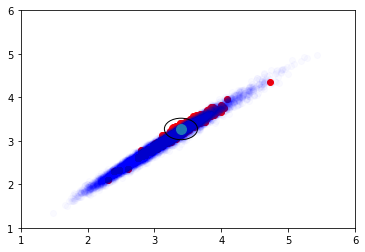

In [55]:
fig, ax = plt.subplots()
ax.scatter(trains[:,0], trains[:,1], color = 'r')
ax.scatter(tests[:,0], tests[:,1], color = 'b', alpha = 0.02)
ax.scatter(center_point[0], center_point[1], s = 100)
a = plt.Circle((center_point[0], center_point[1]), R, fill=False)
ax.set_xlim(1,6)
ax.set_ylim(1,6)
ax.add_artist(a)
plt.show()

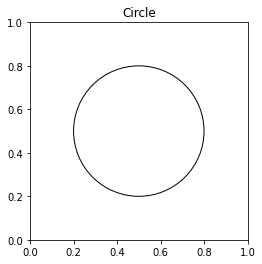

In [46]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
draw_circle = plt.Circle((0.5, 0.5), 0.3,fill=False)

axes.set_aspect(1)
axes.add_artist(draw_circle)
plt.title('Circle')
plt.show()